In [2]:
import change_path
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_recall_curve, roc_curve
import pickle
import cg_annotations
import seaborn as sns


lowercase_map = np.arange(256, dtype=np.uint8)
lowercase_map[np.fromstring("ACGT", dtype=np.uint8)] = np.fromstring("acgt", dtype=np.uint8)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/K27act_models/cg_model/']
loading chr1
loading chr10
loading chr11
loading chr12
loading chr13
loading chr14
loading chr15
loading chr16
loading chr17
loading chr18
loading chr19
loading chr2
loading chr20
loading chr21
loading chr22
loading chr3
loading chr4
loading chr5
loading chr6
loading chr7
loading chr8
loading chr9
loading chrM
loading chrX
loading chrY


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [7]:
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 

# add cg and c.g data
peaks['gc_frac'] = peaks.apply(cg_annotations.gc_frac, axis=1)
peaks['cpg_frac'] = peaks.apply(cg_annotations.cpg_frac, axis=1)

peaks.to_csv('/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed', sep='\t', index=False)

In [8]:
peaks = pd.read_table('/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed')
peaks = peaks[peaks['chr'] != 'chr8']
print(len(peaks))
peaks['start']= (peaks['start']//2+peaks['end']//2 - 500)
peaks['end']= peaks['start'] + 1000
peaks.head()

160363


,chr,start,end,name,fold_change,atac,k27act,nucs,gc_frac,cpg_frac
0,chr1,566310,567310,Peak_1_ENCFF996CVE_dhs,-5.261980,64.213301,0.699504,AAAGGCGGGAGAAGCCCCGGCAGGTTTGAAGCTGCTTCTTCGAATT...,0.470703,0.031250
1,chr1,567076,568076,Peak_2_ENCFF996CVE_dhs,-9.207929,1046.544312,0.771372,GGCATCACTATACTACTAACAGACCGTAACCTCAACACCACCTTCT...,0.435547,0.035156
2,chr1,569422,570422,Peak_3_ENCFF996CVE_dhs,-9.162962,1678.027423,1.929082,GTGATTATAGGCTTTCGCTCTAAGATTAAAAATGCCCTAGCCCACT...,0.442383,0.021484
3,chr1,713414,714414,Peak_19010_ENCFF411MHX_k27,0.396285,22.169786,29.494085,cccatctctagaaaaaaatacaaaaaTTAGGCCAGGTGTccaccgc...,0.583984,0.061523
4,chr1,713622,714622,"Peak_4a_ENCFF996CVE_dhs,Peak_4b_ENCFF996CVE_dh...",-0.339700,32.934289,25.815067,CCTCCCTGTTGCACACCTGGATAGttttttaaatttttttagacag...,0.621094,0.069336


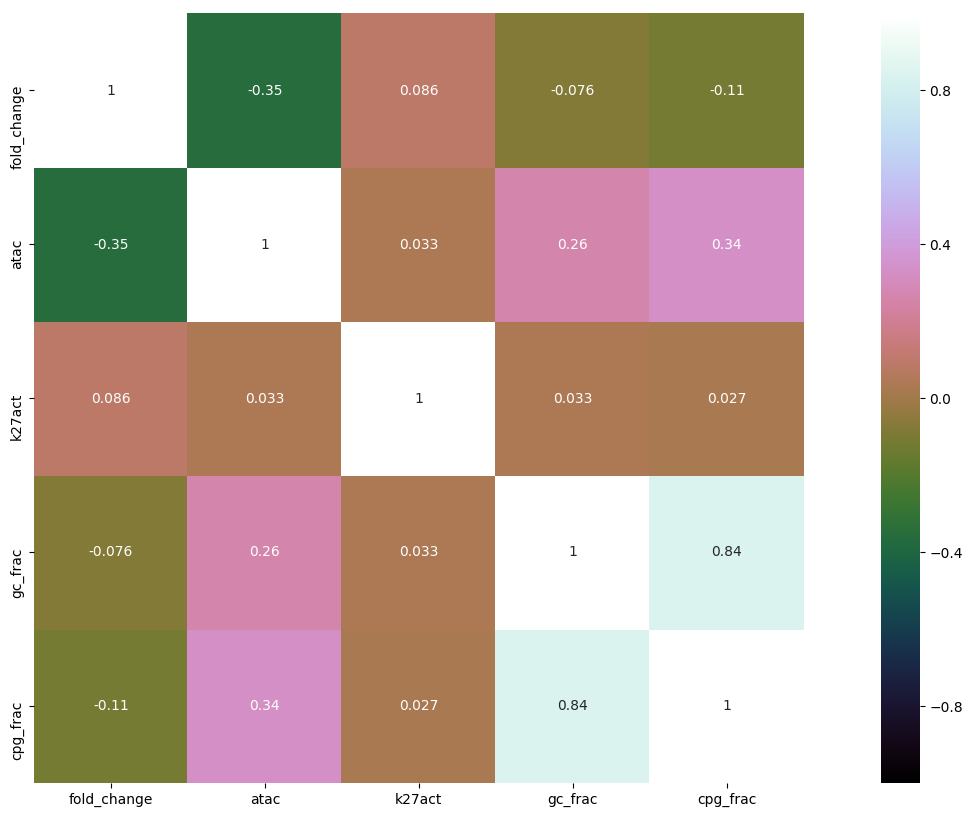

In [9]:
# GETTING Correllation matrix
drop_peaks = peaks.copy()
drop_peaks.drop(['start', 'end'],axis=1,inplace=True)
corr_mat=drop_peaks.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')
plt.show()

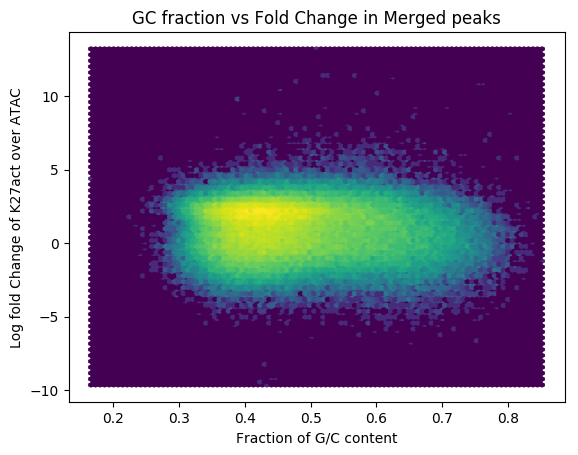

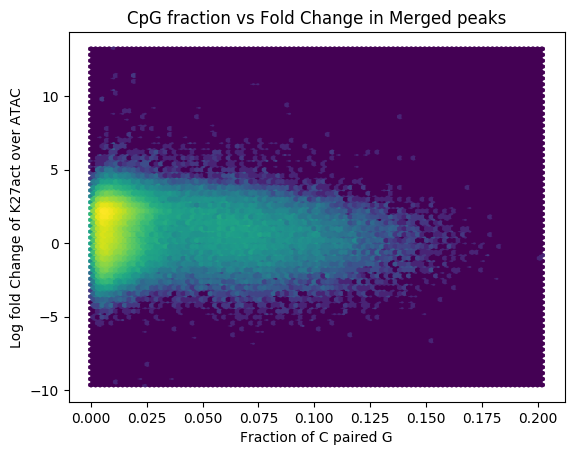

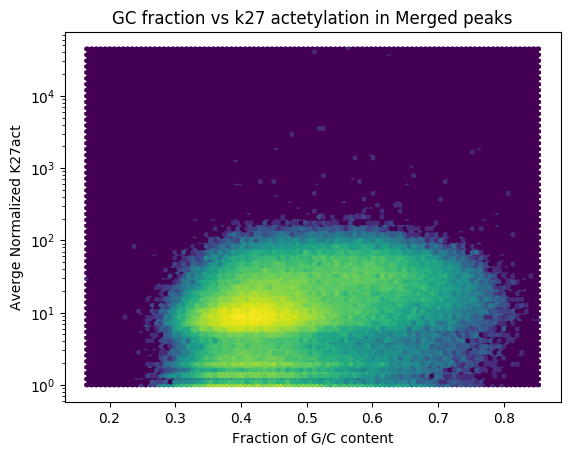

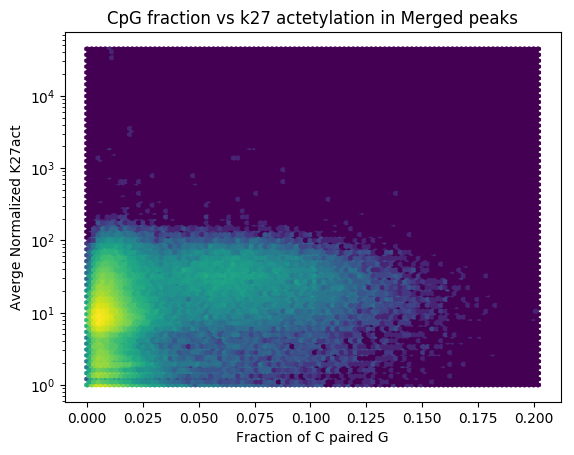

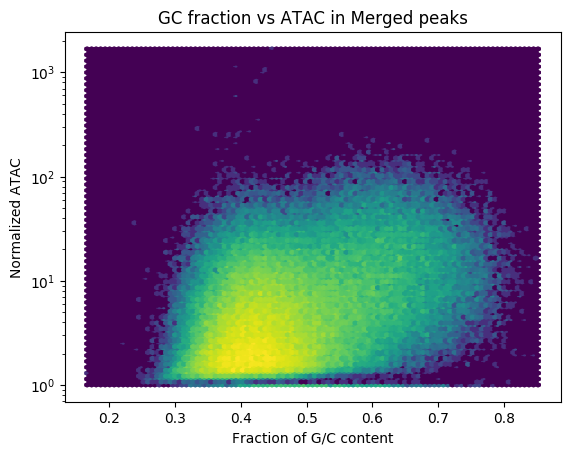

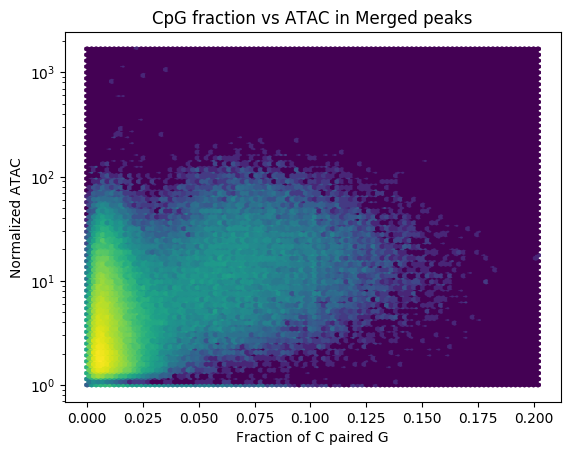

In [102]:
# make some charts
plt.title('GC fraction vs Fold Change in Merged peaks')
plt.ylabel('Log fold Change of K27act over ATAC')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['fold_change'], bins='log')
plt.show()

plt.title('CpG fraction vs Fold Change in Merged peaks')
plt.ylabel('Log fold Change of K27act over ATAC')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['fold_change'], bins='log')
plt.show()

plt.title('GC fraction vs k27 actetylation in Merged peaks')
plt.ylabel('Averge Normalized K27act')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['k27act_norm']+1, bins='log', yscale='log')
plt.show()

plt.title('CpG fraction vs k27 actetylation in Merged peaks')
plt.ylabel('Averge Normalized K27act')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['k27act_norm'] +1, bins='log', yscale='log')
plt.show()

plt.title('GC fraction vs ATAC in Merged peaks')
plt.ylabel('Normalized ATAC')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['atac_norm']+1, bins='log', yscale='log')
plt.show()

plt.title('CpG fraction vs ATAC in Merged peaks')
plt.ylabel('Normalized ATAC')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['atac_norm'] +1, bins='log', yscale='log')
plt.show()

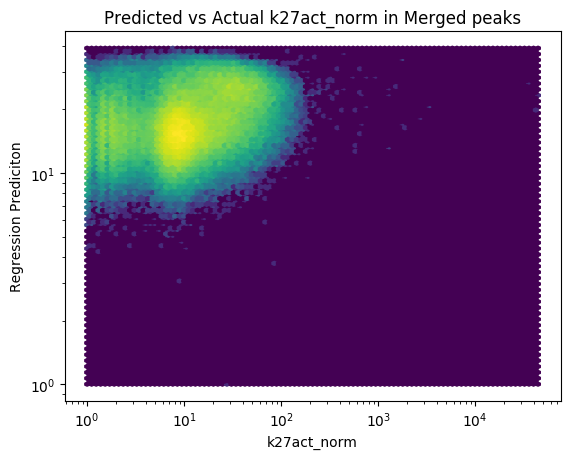

gc_frac coeffs: 59.04205492856184
cpg_frac coeffs: -6.7764544026381195
intercept: -10.99772634201836
MSE: 31350.075254674593


In [109]:
predicted_feature='k27act_norm'

# build a regresion model
lm_2 = LinearRegression()
poly_2 = PolynomialFeatures(1, interaction_only=True)
lm_2.fit(peaks[['gc_frac','cpg_frac']], peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_2=lm_2.predict(peaks[['gc_frac','cpg_frac']]).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_2+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_2, bins='log', extent=(-10, 10, -10, 10))
plt.show()

print('gc_frac coeffs: ' + str(lm_2.coef_[0]))
print('cpg_frac coeffs: ' + str(lm_2.coef_[1]))
print('intercept: ' + str(lm_2.intercept_))

#calculate error
mse_2 = np.mean((peaks[predicted_feature] - preds_2) **2)
print('MSE: ' + str(mse_2))

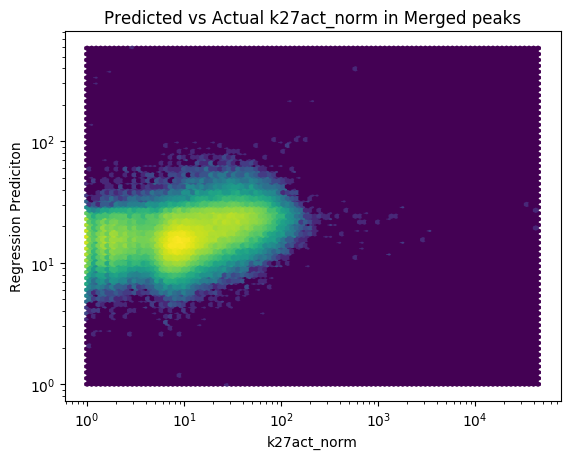

gc_frac coeff: 62.8907270392206
cpg_frac coeff: -78.27204743666897
atac coeff: 0.3413457145367431
intercept: -13.809589470240496
MSE: 31327.859271613295


In [110]:
# build a regresion model
lm_3 = LinearRegression()
lm_3.fit(peaks[['gc_frac','cpg_frac', 'atac_norm']], peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_3=lm_3.predict(peaks[['gc_frac','cpg_frac', 'atac_norm']]).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_3+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_3, bins='log', extent=(-10, 10, -10, 10))
plt.show()

print('gc_frac coeff: ' + str(lm_3.coef_[0]))
print('cpg_frac coeff: ' + str(lm_3.coef_[1]))
print('atac coeff: ' + str(lm_3.coef_[2]))
print('intercept: ' + str(lm_3.intercept_))

#calculate error
mse_3 = np.mean((peaks[predicted_feature] - preds_3) **2)
print('MSE: ' + str(mse_3))

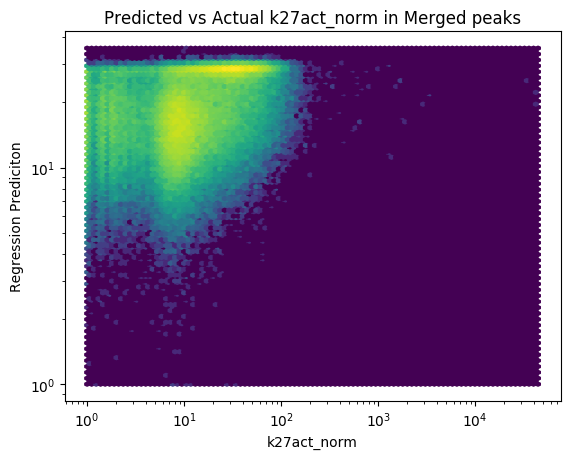

1: 0.0
x0: 64.19666627174882
x1: 861.4891850190883
x0 x1: -1276.3448291239172
gc_frac: x0
cpg_frac: x1
intercept: -16.691363425030946
MSE: 31340.093519926006


In [111]:
# build a regresion model

poly_2i = PolynomialFeatures(2, interaction_only=True)
fit_data = poly_2i.fit_transform(peaks[['gc_frac','cpg_frac']])

lm_2i = LinearRegression()
lm_2i.fit(fit_data, peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_2i=lm_2i.predict(fit_data).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_2i+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_2i, bins='log', extent=(-10, 10, -10, 10))
plt.show()

for name, co in zip(poly_2i.get_feature_names(), lm_2i.coef_):
    print(name + ': ' + str(co))
print('gc_frac: x0')
print('cpg_frac: x1')
print('intercept: ' + str(lm_2i.intercept_))

#calculate error
mse_2i = np.mean((peaks[predicted_feature] - preds_2i) **2)
print('MSE: ' + str(mse_2i))

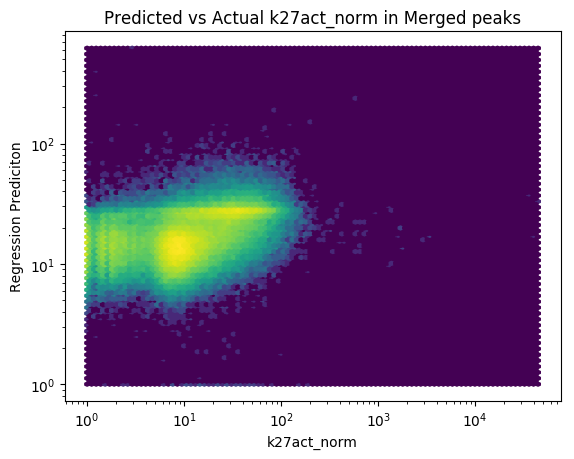

1: 0.0
x0: 34.84660260756482
x1: 782.4931387461262
x2: -1.298594902331832
x0 x1: -1030.499679002818
x0 x2: 4.62826117229949
x1 x2: -18.01485552468138
gc_frac: x0
cpg_frac: x1
atac: x2
intercept: -7.268985693277713
MSE: 31309.072006087306


In [112]:
# build a regresion model

poly_3i = PolynomialFeatures(2, interaction_only=True)
fit_data = poly_3i.fit_transform(peaks[['gc_frac','cpg_frac', 'atac_norm']])

lm_3i = LinearRegression()
lm_3i.fit(fit_data, peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_3i=lm_3i.predict(fit_data).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_3i+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_3i, bins='log', extent=(-10, 10, -10, 10))
plt.show()

for name, co in zip(poly_3i.get_feature_names(), lm_3i.coef_):
    print(name + ': ' + str(co))
print('gc_frac: x0')
print('cpg_frac: x1')
print('atac: x2')
print('intercept: ' + str(lm_3i.intercept_))

#calculate error
mse_3i = np.mean((peaks[predicted_feature] - preds_3i) **2)
print('MSE: ' + str(mse_3i))

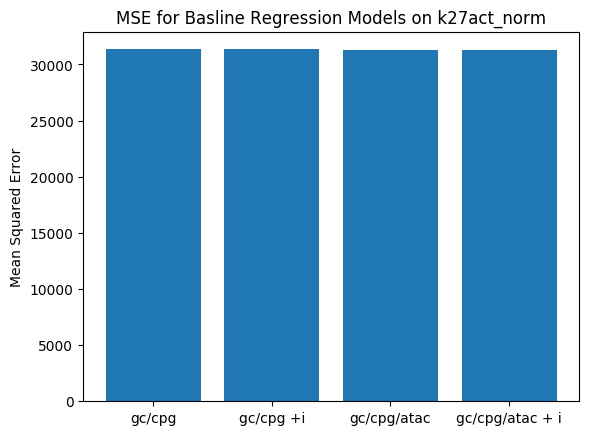

In [113]:
plt.bar([1,2,3,4], [mse_2, mse_2i, mse_3, mse_3i])
plt.xticks([1, 2, 3, 4], ['gc/cpg', 'gc/cpg +i', 'gc/cpg/atac', 'gc/cpg/atac + i'])
plt.title('MSE for Basline Regression Models on ' + predicted_feature)
plt.ylabel('Mean Squared Error')
#plt.ylim((30000, 30100))
plt.show()

In [114]:
pickle.dump(lm_2, open('cg_cpg_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_2i, open('cg_cpg_i_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_3, open('cg_cpg_atac_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_3i, open('cg_cpg_atac_i_regression_{}.pk'.format(predicted_feature), 'wb'))

In [70]:
if predicted_feature == 'k27act_norm':
    preds_2 = np.log2((preds_2+1)/(peaks['atac_norm']+1))
    preds_3 = np.log2((preds_3+1)/(peaks['atac_norm']+1))
    preds_2i = np.log2((preds_2i+1)/(peaks['atac_norm']+1))
    preds_3i = np.log2((preds_3i+1)/(peaks['atac_norm']+1))

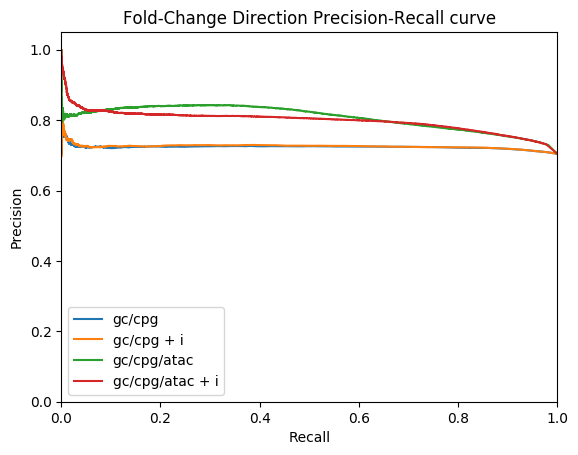

In [71]:
# pr curve
p_2, r_2, t = precision_recall_curve(peaks['fold_change']>0, preds_2)
p_2i, r_2i, t = precision_recall_curve(peaks['fold_change']>0, preds_2i)
p_3, r_3, t = precision_recall_curve(peaks['fold_change']>0, preds_3)
p_3i, r_3i, t = precision_recall_curve(peaks['fold_change']>0, preds_3i)


plt.plot(r_2, p_2, label='gc/cpg')
plt.plot(r_2i, p_2i, label='gc/cpg + i')
plt.plot(r_3, p_3, label='gc/cpg/atac')
plt.plot(r_3i, p_3i, label='gc/cpg/atac + i')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction Precision-Recall curve')
plt.show()

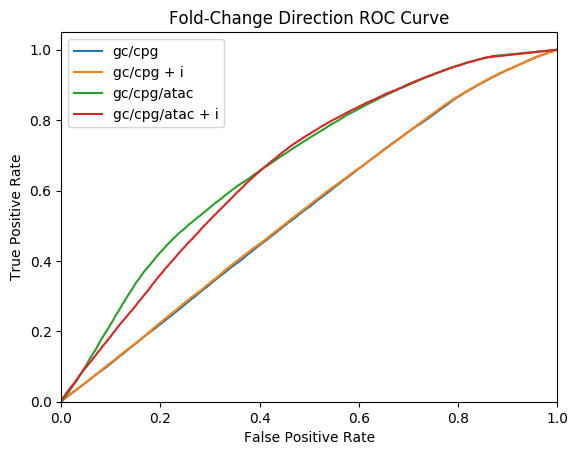

In [72]:
# roc curve
fpr_2, tpr_2, t = roc_curve(peaks['fold_change']>0, preds_2)
fpr_2i, tpr_2i, t = roc_curve(peaks['fold_change']>0, preds_2i)
fpr_3, tpr_3, t = roc_curve(peaks['fold_change']>0, preds_3)
fpr_3i, tpr_3i, t = roc_curve(peaks['fold_change']>0, preds_3i)


plt.plot(fpr_2, tpr_2, label='gc/cpg')
plt.plot(fpr_2i, tpr_2i, label='gc/cpg + i')
plt.plot(fpr_3, tpr_3, label='gc/cpg/atac')
plt.plot(fpr_3i, tpr_3i, label='gc/cpg/atac + i')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction ROC Curve')
plt.show()

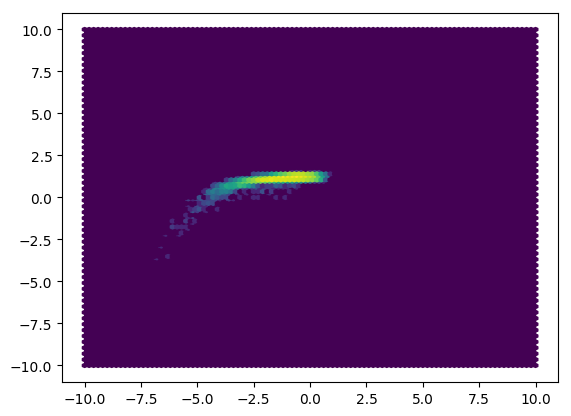

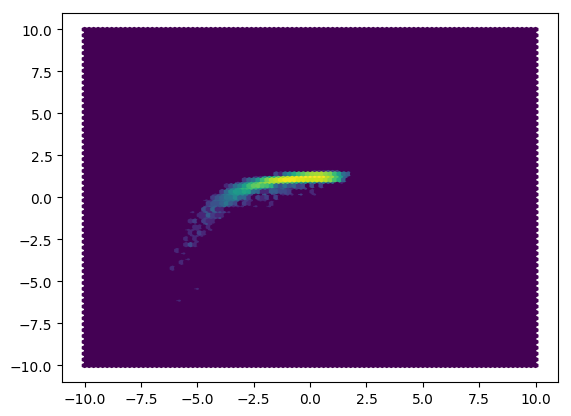

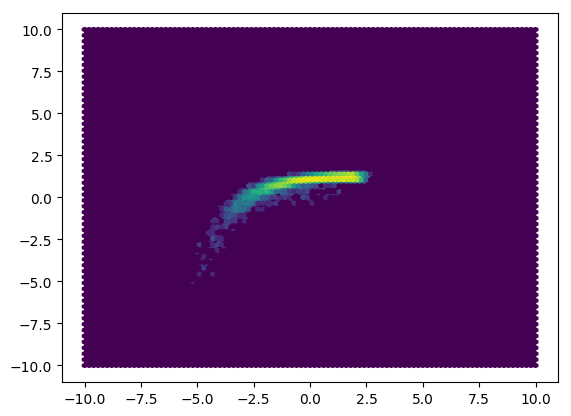

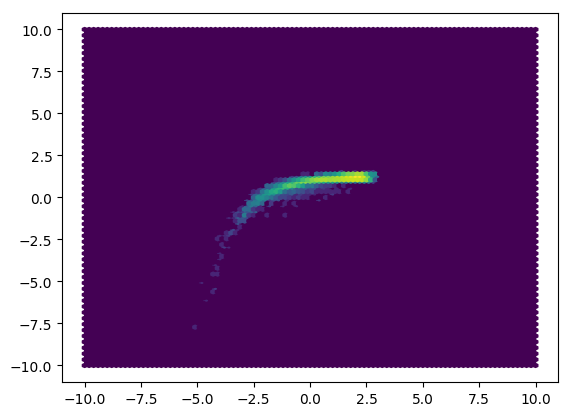

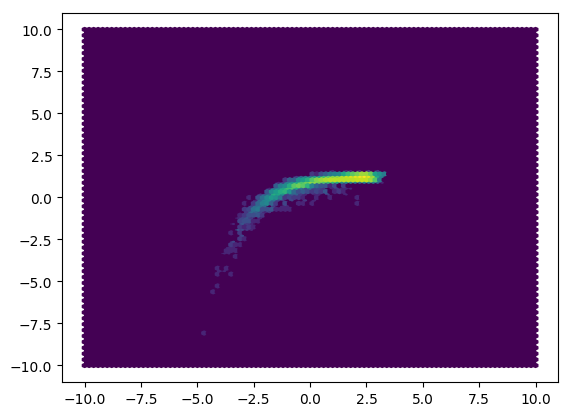

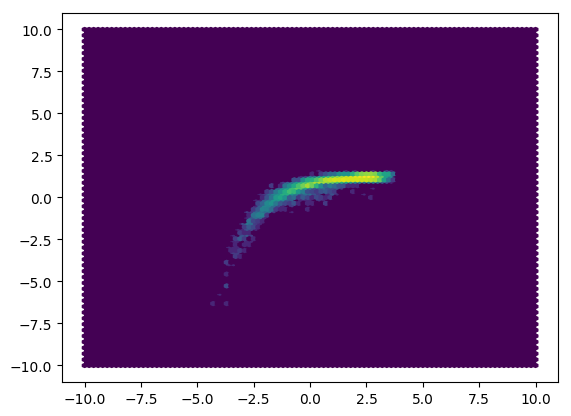

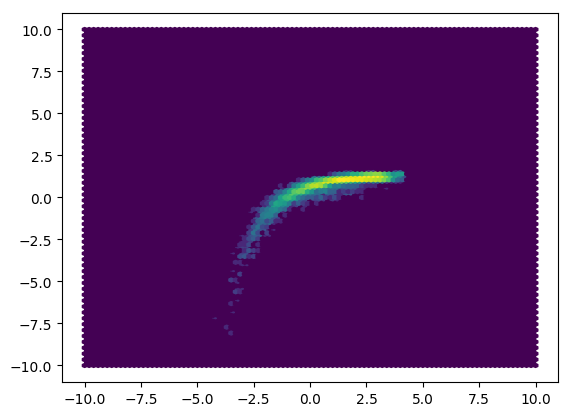

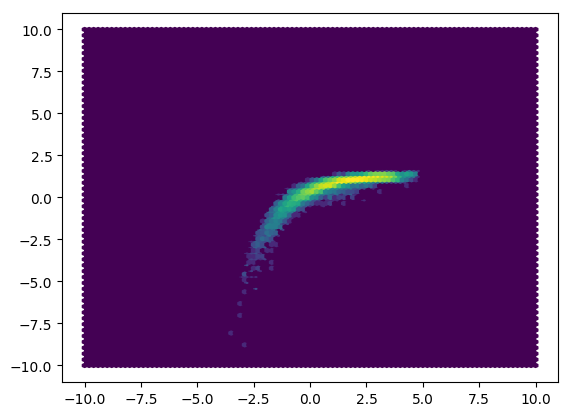

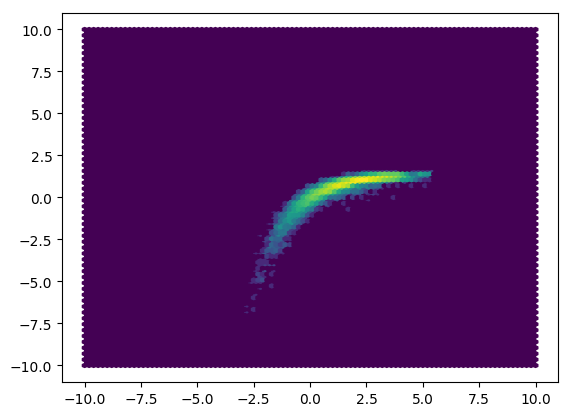

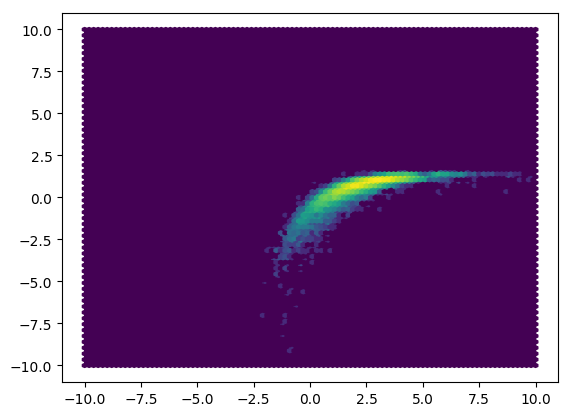

In [84]:
# stratefied hexbins
model = lm_3i
poly = poly_2
num_groups = 10
split_column = 'k27act_norm'

mse=dict()
p=dict()
r=dict()
fpr=dict()
tpr=dict()
names=dict()

for i in range(num_groups):
    # get quintile values
    min_fold, max_fold = peaks.quantile([i/num_groups, (i+1)/num_groups])[split_column]
    names[i]='{:.2}-{:.2}'.format(min_fold, max_fold)
    subset_peaks = peaks[(peaks[split_column] >= min_fold) & (peaks[split_column] < max_fold)]
    fit_data = poly_3i.fit_transform(subset_peaks[['gc_frac','cpg_frac', 'atac_norm']])
    preds = model.predict(fit_data)
    if predicted_feature == 'k27act_norm':
        preds = np.log2((preds+1)/(subset_peaks['atac_norm']+1))
    
    #make a plot
    plt.hexbin(subset_peaks['fold_change'], preds, bins='log', extent=(-10, 10, -10, 10))
    plt.show()

    #calculate error
    mse[i] = np.mean((subset_peaks['fold_change'] - preds) **2)
    p[i], r[i], t = precision_recall_curve(subset_peaks['fold_change']>0, preds)
    fpr[i], tpr[i], t = roc_curve(subset_peaks['fold_change']>0, preds)

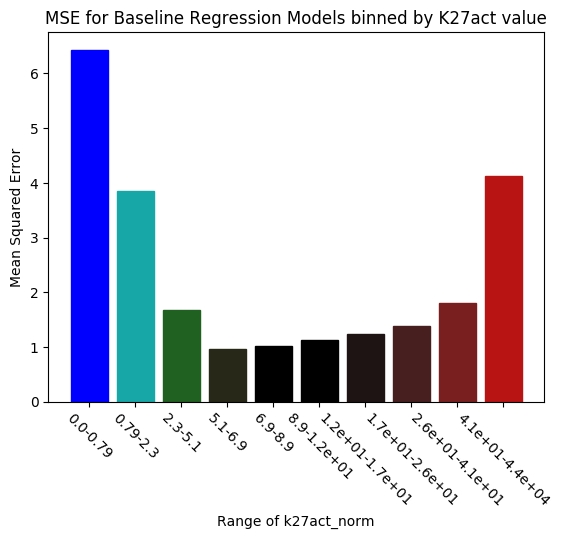

In [85]:
from colour import Color
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("black"), num_groups//2))
[colors.append(c) for c in (Color("black").range_to(Color("red"), num_groups//2+1))]

# make an mse plot
barlist = plt.bar(range(num_groups), mse.values())
for i in range(num_groups):
    barlist[i].set_color(colors[i].rgb)

plt.xticks(range(num_groups), names.values(), rotation=-45)
plt.xlabel('Range of {}'.format(split_column))
plt.title('MSE for Baseline Regression Models binned by K27act value')
plt.ylabel('Mean Squared Error')
plt.show()

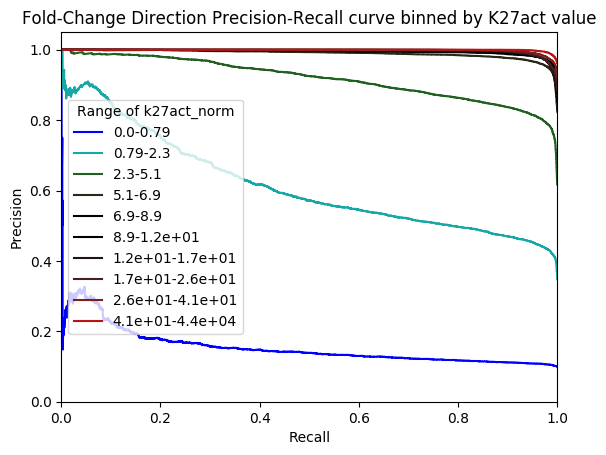

In [86]:
for i in range(num_groups):
    plt.plot(r[i], p[i], label=names[i], color=colors[i].rgb)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(title='Range of {}'.format(split_column))
plt.title('Fold-Change Direction Precision-Recall curve binned by K27act value')
plt.show()

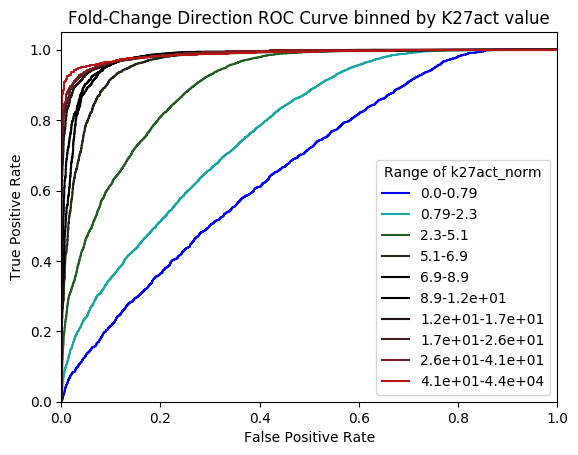

In [87]:
for i in range(num_groups):
    plt.plot(fpr[i], tpr[i], label=names[i], color=colors[i].rgb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(title='Range of {}'.format(split_column))
plt.title('Fold-Change Direction ROC Curve binned by K27act value')
plt.show()